In [1]:
%matplotlib inline

import sys
import numpy as np
import scipy
import torch
from torch.autograd import Variable
import sklearn
import sklearn.datasets
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial

sns.set_style('darkgrid')
np.random.seed(42)
# Print versions used
print('Python: {}.{}.{}'.format(*sys.version_info[:3]))
print('numpy: {}'.format(np.__version__))
print('torch: {}'.format(torch.__version__))
print('sklearn: {}'.format(sklearn.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('seaborn: {}'.format(sns.__version__))
#

Python: 3.7.0
numpy: 1.15.2
torch: 1.0.0.dev20181007
sklearn: 0.20.0
matplotlib: 3.0.0
seaborn: 0.9.0


In [2]:
def print_debug(x, s):
    print(s, type(x), x.dtype, x.shape)

In [3]:
# dataset = sklearn.datasets.fetch_openml(
#     'mauna-loa-atmospheric-co2')
# print('dataset: ', type(dataset))
# print(dir(dataset))
# print('data: ', type(data), data.dtype, data.shape)
# X = data[:, [1]]
# y = data[:, 0]
# print('X: ', X.shape)
# print('y: ', y.shape)

# plt.plot(X, y)
# plt.show()

In [4]:
EPS = 1e-6

In [5]:
# def dist(xa, xb):
#     mmp1 = torch.stack([xa]*xa.shape[0])
#     print('mmp1: ', mmp1.shape)
#     mmp2 = torch.stack([xb]*xb.shape[0]).transpose(0,1)
#     print('mmp2: ', mmp2.shape)
#     mm = torch.sum((mmp1-mmp2)**2,2).squeeze()
#     print('mm: ', mm.shape)
#     return mm

In [6]:
# # Sample from the Gaussian process distribution
# nb_of_samples = 75  # Number of test points.
# number_of_functions = 5  # Number of functions to sample
# # Independent variable samples
# X = torch.tensor(np.expand_dims(np.linspace(-4, 4, nb_of_samples), 1))
# print('X: ', type(X), X.dtype, X.shape)
# # dist = torch.nn.PairwiseDistance(p=2, eps=1e-06, keepdim=False)
# # dist = torch.pairwise_distances(X[..., None, :, :], X[..., None, :])
# # print('dist: ', type(dist))
# # K = torch.exp(-1 * dist(X, X))
# d = dist(X, X)
# print('d: ', type(d), d.dtype, d.shape)
# K = torch.exp(-1 * d)
# print('K: ', type(K), K.dtype, K.shape)

# # Small constant to ensure positive definite kernel
# #  (also known as Tikhonov matrix)
# tikhonov_matrix = torch.tensor(1e-10 * np.eye(nb_of_samples))

# # Draw samples from the prior at our data points.
# # L = np.linalg.cholesky(K + tikhonov_matrix)
# K = K + tikhonov_matrix
# print('K: ', type(K), K.dtype, K.shape)
# L = torch.potrf(K, upper=False)
# print('L: ', type(L), L.dtype, L.shape)
# std_normal = torch.tensor(np.random.normal(
#     size=(nb_of_samples, number_of_functions)))
# print('std_normal: ', type(std_normal), std_normal.dtype, std_normal.shape)
# y = L @ std_normal
# print('y: ', type(y), y.dtype, y.shape)

In [7]:
# # Plot the sampled functions
# plt.plot(X.numpy(), y.numpy(), 'o')
# plt.xlabel('$x$', fontsize=15)
# plt.ylabel('$y$', fontsize=15)
# plt.title('Evaluations sampled from 5 functions from Gaussian process')
# plt.xlim([-4, 4])
# plt.show()
# #

In [8]:
# Define the true function that we want to regress on
f_sin = lambda x: (np.sin(x)).flatten()

n1 = 20  # Number of points to condition on (training points)
n2 = 100
# RBF Kernel function with width set
kernel = lambda xa, xb: rbf_kernel(xa, xb)
domain = (-10, 10)

# Sample some points (X1, y1) on the function
X1 = torch.tensor(np.random.uniform(*domain, size=(n1,1)))
y1 = f_sin(X1.numpy())
noise = 0.2 # The variance of the noise
# Add noise to the samples we sampled previously
y1_noisy = torch.tensor(np.expand_dims(
    y1 + noise * np.random.randn(n1), 1))



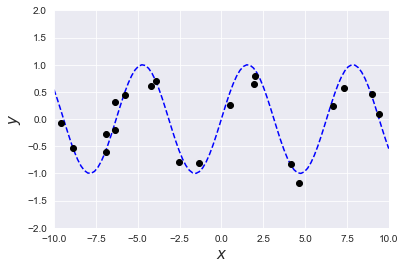

In [9]:
# Predict points at uniform spacing to capture function
X2 = np.linspace(*domain, n2).reshape(-1,1)

# Plot the postior distribution and some samples
fig, ax1 = plt.subplots(nrows=1, ncols=1)
# Plot the distribution of the function (mean, covariance)
ax1.plot(X2, f_sin(X2), 'b--', label='$sin(x)$')
ax1.plot(X1.numpy(), y1_noisy.numpy(), 'ko', linewidth=2, label='$(x_1, y_1)$')
ax1.set_xlabel('$x$', fontsize=15)
ax1.set_ylabel('$y$', fontsize=15)
ax1.axis([*domain, -2, 2])
plt.show()
#

In [10]:
# Define the periodic kernel
def periodic_kernel(xa, xb, l, p):
    """Periodic kernel"""
#     print_debug(xa, 'xa')
#     print_debug(xb, 'xb')
    n = xa.size(0)
    m = xb.size(0)
    d = xa.size(1)
    # L1 distance (Manhattan or cityblock)
#     _xa_stack = torch.stack([xa]*xa.shape[0])
#     print_debug(_xa_stack, '_xa_stack')
#     _xb_stack = torch.stack([xb]*xb.shape[0]).transpose(0,1)
#     print_debug(_xb_stack, '_xb_stack')
    xa = xa.unsqueeze(1).expand(n, m, d)
    xb = xb.unsqueeze(0).expand(n, m, d)
#     print_debug(xa, 'xa')
#     print_debug(xb, 'xb')
    pdiff = torch.sum(torch.abs(xa-xb),2).squeeze()
#     print_debug(pdiff, 'pdiff')
    return torch.exp(-2*l**2 * torch.sin(p*pdiff)**2)

def noise_kernel(xa, xb, s):
    return s**2 * torch.eye(xa.shape[0]).double()

In [11]:
s_noise = Variable(torch.ones(1).double(), requires_grad=True)
s_noise.retain_grad()
print_debug(s_noise, 's_noise')
print(s_noise.is_leaf)

s_noise <class 'torch.Tensor'> torch.float64 torch.Size([1])
True


In [12]:
periodic_amplitude = Variable(torch.ones(1).double(), requires_grad=True)
periodic_amplitude.retain_grad()
periodic_period = Variable(torch.ones(1).double(), requires_grad=True)
periodic_period.retain_grad()
print_debug(periodic_amplitude, 'periodic_amplitude')
print(periodic_amplitude.is_leaf)
print_debug(periodic_period, 'periodic_period')
print(periodic_period.is_leaf)

periodic_amplitude <class 'torch.Tensor'> torch.float64 torch.Size([1])
True
periodic_period <class 'torch.Tensor'> torch.float64 torch.Size([1])
True


$$
p(\mathbf{y} \mid \mathbf{\mu}, \Sigma) = \frac{1}{\sqrt{(2\pi)^d \lvert\Sigma\rvert}} e^{\textstyle \left( -\frac{1}{2}(\mathbf{y} - \mathbf{\mu})^T \Sigma^{-1} (\mathbf{y} - \mathbf{\mu}) \right)}
$$

$\mu = 0$, $\Sigma \approx K = k_{\theta}(X, X)$

$$
\log p(\mathbf{y} \mid X, \theta) = -\log {\sqrt{(2\pi)^d \lvert K \rvert}} +{\textstyle \left( -\frac{1}{2}(\mathbf{y})^T K^{-1} (\mathbf{y}) \right)}
$$

$$
\log p(\mathbf{y} \mid X, \theta) = -\frac{1}{2}\mathbf{y}^\top K^{-1} \mathbf{y} -\frac{1}{2}\log{|K|} -\frac{d}{2}\log{2\pi}
$$

In [13]:
def kernel_func(xa, xb): 
    Ka = periodic_kernel(
        xa, xb, 
        l=periodic_amplitude, p=periodic_period)
#     print_debug(Ka, 'Ka')
    Kb = noise_kernel(xa, xb, s=s_noise)
#     print_debug(Kb, 'Kb')
    Kc = EPS * torch.eye(xa.shape[0]).double()
#     print_debug(Kc, 'Kc')
    return Ka + Kc

def neg_log_likelihood(X, y, kernel_func):
#     print_debug(X, 'X')
#     print_debug(y, 'y')
    K = kernel_func(X, X)
#     print_debug(K, 'K')
    L = torch.potrf(K, upper=False)
#     print_debug(L, 'L')
    # Determinant of triangular matrix is product of diagonal
    det = L.diag().prod()**2
    
#     print(L.diag().detach().numpy())
#     print_debug(det, 'det')
#     print(det.detach().numpy())
#     print(np.linalg.det(K.detach().numpy()))
#     print(np.log(det.detach().item()))
    log_det = torch.log(L.diag()).sum()*2
#     print(log_det.item())
    # Todo assert detreminant is correct
#     return (
#         ( (1./2) * (y.t() @ L.t() @ L @ y)) * (-1./2) * ( \
#         log_det + \
#         X.shape[0]*torch.log(torch.tensor([2*np.pi]).double()))) + 100*s_noise**2
    #     Ly1 = np.linalg.solve(L11, y1)  # y1 / L11
#     yL = torch.trtrs(y.t(),  L.t())  # y1 / L11
#     Ky = torch.potrs(y, L, upper=False)
    Ky = torch.trtrs(y, K)[0]
    return (1./2) * (
        (y.t() @ Ky) + log_det + X.shape[0]*torch.log(torch.tensor([2*np.pi]).double()))

In [14]:
loss = neg_log_likelihood(X1, y1_noisy, kernel_func)
print('loss: ', type(loss), loss.dtype, loss.shape)
print(loss.item())

loss:  <class 'torch.Tensor'> torch.float64 torch.Size([1, 1])
-46.826496121357124


In [15]:
# periodic_amplitude.register_hook(print)
# periodic_period.register_hook(print)
# periodic_amplitude.retain_grad()
# periodic_period.retain_grad()

In [16]:
# loss.backward()
# with torch.no_grad():
#     print(periodic_amplitude.grad)
#     print(periodic_period.grad)
#     periodic_amplitude.grad.zero_()
#     periodic_period.grad.zero_()

In [26]:
learning_rate = 0.02
optimizer = torch.optim.Adam([
    periodic_amplitude, periodic_period], 
    lr=learning_rate)

In [33]:
for t in range(10000):
    loss = neg_log_likelihood(X1, y1_noisy, kernel_func)
    if t % 100 == 0:
        print(loss.item(), t)
#         print(np.exp(-loss.item()), t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

-100.03193097985523 0
-98.25067573034686 100
-96.53097768255326 200
-99.55002964262657 300
-95.30098584642352 400
-92.70900273772521 500
-90.24016191007752 600
-94.08178269530151 700
-100.44137330989231 800
-101.11460956856055 900
-99.88841556171715 1000
-98.90138242028894 1100
-93.02917911975737 1200
-102.0623188166489 1300
-97.10577611557311 1400
-96.63154007060247 1500
-97.75160190500021 1600
-98.0100076301862 1700
-101.23295115660285 1800
-100.65457977456894 1900
-99.46125698510862 2000
-93.13034185305584 2100
-97.1345385075025 2200
-97.18943114185451 2300
-100.35268848225898 2400
-92.94689644453034 2500
-97.60868374986434 2600
-98.60558239677214 2700
-102.70201798804285 2800
-99.64205232285279 2900
-96.42701266020627 3000
-96.54609916276543 3100
-100.23826657538476 3200
-90.39653640123274 3300
-100.52622597819766 3400
-96.9928242565329 3500
-99.20025285037725 3600
-97.28690606441276 3700
-106.0986166668915 3800
-96.1862521806723 3900
-99.22663343963062 4000
-99.17531754286375 4100

In [37]:
print(periodic_amplitude.item())
print(periodic_period.item())
print(s_noise.item())

-0.009866521228165857
1.1764314107669078
1.0


In [38]:
# Predict points at uniform spacing to capture function
X2 = torch.tensor(np.linspace(*domain, n2).reshape(-1,1)).double()
print_debug(X2, 'X2')

X2 <class 'torch.Tensor'> torch.float64 torch.Size([100, 1])


In [39]:
# Gaussian process posterior
def GP(X1, y1, X2, kernel_func):
    # Kernel of the samples. K11 = L11 * L11^T
    K11 = kernel_func(X1, X1)
    print_debug(K11, 'K11')
    # Add Jitter to ensure positive definte
    L11 = torch.potrf(K11, upper=False)
    print_debug(L11, 'L11')
    # Compute K12/L11 to be used when computing the posterior
    K12 = periodic_kernel(
        X1, X2, 
        l=periodic_amplitude, p=periodic_period)
    print_debug(K12, 'K12')
#     LK12_numpy = np.linalg.solve(L11.numpy(), K12.numpy)  # K12 / L11
#     print('LK12_numpy[3][: ')
    LK12 = torch.trtrs(K12, L11, upper=False)[0]
    print_debug(LK12, 'LK12')
    # Compute the posterior mean
#     Ly1 = np.linalg.solve(L11, y1)  # y1 / L11
    Ly1 = torch.trtrs(y1, L11, upper=False)[0]
    print_debug(Ly1, 'Ly1')
    mu2 = LK12.t() @ Ly1
    print_debug(mu2, 'v')
    # Compute the posterior covariance
    K22 = kernel_func(X2, X2)
    print_debug(K22, 'K22')
    S21 = K22 - (LK12.t() @ LK12)
    print_debug(S21, 'S21')
    return mu2, S21

In [40]:
print_debug(X1, 'X1')
print_debug(y1_noisy, 'y1_noisy')
print_debug(X2, 'X2')
mean_noise, cov_noise = GP(X1, y1_noisy, X2, kernel_func)
print_debug(mean_noise, 'mean_noise')
print_debug(cov_noise, 'cov_noise')
std = torch.sqrt(torch.diag(cov_noise))
print_debug(std, 'std')

X1 <class 'torch.Tensor'> torch.float64 torch.Size([20, 1])
y1_noisy <class 'torch.Tensor'> torch.float64 torch.Size([20, 1])
X2 <class 'torch.Tensor'> torch.float64 torch.Size([100, 1])
K11 <class 'torch.Tensor'> torch.float64 torch.Size([20, 20])
L11 <class 'torch.Tensor'> torch.float64 torch.Size([20, 20])
K12 <class 'torch.Tensor'> torch.float64 torch.Size([20, 100])
LK12 <class 'torch.Tensor'> torch.float64 torch.Size([20, 100])
Ly1 <class 'torch.Tensor'> torch.float64 torch.Size([20, 1])
v <class 'torch.Tensor'> torch.float64 torch.Size([100, 1])
K22 <class 'torch.Tensor'> torch.float64 torch.Size([100, 100])
S21 <class 'torch.Tensor'> torch.float64 torch.Size([100, 100])
mean_noise <class 'torch.Tensor'> torch.float64 torch.Size([100, 1])
cov_noise <class 'torch.Tensor'> torch.float64 torch.Size([100, 100])
std <class 'torch.Tensor'> torch.float64 torch.Size([100])


std_eval <class 'numpy.ndarray'> float64 (100,)
[-0.08468998 -0.08113217 -0.06582579 -0.04045771 -0.0077467   0.02672541
  0.05435183  0.06621634  0.05740829  0.03002142 -0.0074283  -0.04393813
 -0.07071956 -0.08372798 -0.08297344 -0.07009404 -0.04676073 -0.01529913
  0.01944071  0.04937917  0.06531449  0.06111072  0.03723866  0.00105787
 -0.03654643 -0.06597556 -0.0821021  -0.08423603 -0.07386061 -0.05266478
 -0.02268089  0.01193186  0.04372483  0.06342256  0.06384429  0.04385304
  0.0094818  -0.02874492 -0.06057726 -0.07979899 -0.08490083 -0.07710937
 -0.05814013 -0.02982726  0.00429652  0.03748414  0.06058421  0.06557223
  0.04976147  0.01772297 -0.02062052 -0.05455648 -0.07681008 -0.08494828
 -0.07982426 -0.06316215 -0.03668219 -0.00337287  0.03075715  0.05685811
  0.06627575  0.05487198  0.02565983 -0.01227064 -0.04795692 -0.07313317
 -0.08435909 -0.08198864 -0.06771013 -0.04319794 -0.01099056  0.02364619
  0.05231605  0.06595422  0.05910597  0.03317243 -0.00380178 -0.04083458
 -0

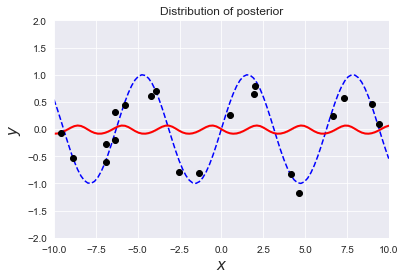

In [41]:
std_eval = std.detach().numpy()
print_debug(std_eval, 'std_eval')
mean_noise_eval = mean_noise.detach().numpy().squeeze()
print(mean_noise_eval)
print_debug(mean_noise_eval, 'mean_noise_eval')

# Plot the postior distribution and some samples
fig, ax1 = plt.subplots(nrows=1, ncols=1)
# Plot the distribution of the function (mean, covariance)
ax1.plot(X2.numpy(), f_sin(X2.numpy()), 'b--', label='$sin(x)$')
ax1.fill_between(
    X2.numpy().squeeze(), 
    mean_noise_eval-2*std_eval, 
    mean_noise_eval+2*std_eval, 
    color='lightgrey', label='$2\sigma_2$')
ax1.plot(X2.numpy(), mean_noise_eval, 'r-', lw=2, label='$\mu_2$')
ax1.plot(X1.numpy(), y1_noisy.numpy(), 'ko', linewidth=2, label='$(x_1, y_1)$')
ax1.set_xlabel('$x$', fontsize=15)
ax1.set_ylabel('$y$', fontsize=15)
ax1.set_title('Distribution of posterior')
ax1.axis([*domain, -2, 2])
plt.show()
#

- [Cost function could be marginal likelihood](https://pdfs.semanticscholar.org/aa65/042ae494455a14811927eb0574871d276454.pdf)
- https://chrischoy.github.io/research/learning-gaussian-process-covariances/
- [GPflow](https://github.com/GPflow/GPflow)
- [GPflow paper](https://arxiv.org/abs/1610.08733)
- https://blog.dominodatalab.com/fitting-gaussian-process-models-python/

- [Lazy tensor PyTorch](https://github.com/cornellius-gp/gpytorch/blob/01cf8a298fc53fb77d30ee649fbac6cb8c54826e/gpytorch/lazy/lazy_tensor.py#L16)
- [GPytorch](https://github.com/cornellius-gp/gpytorch/tree/master/examples)

- [mauna-loa-atmospheric-co2 openml data](https://www.openml.org/d/41187)
- [Sklearn CO2 data](http://scikit-learn.org/dev/auto_examples/gaussian_process/plot_gpr_co2.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-co2-py)
- [PyMC3 CO2](https://docs.pymc.io/notebooks/GP-MaunaLoa.html)
- [PyTorch examples](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html)
- [GP TFp](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/GaussianProcess)
- [Scalable Gaussian process inference using variational methods](http://mlg.eng.cam.ac.uk/matthews/thesis.pdf)